# Debate multi-agent pattern

Some of the best ideas emerge not from a single perspective but from vigorous discussion and critique between different viewpoints. Just as academic debates or peer review processes improve thinking through constructive disagreement, AI agents can benefit from a similar adversarial collaboration.

The debate multi-agent pattern is a collaborative approach where multiple autonomous agents propose different solutions, perspectives or arguments, then critique and challenge each other's ideas through iterative rounds of debate. Through this process of proposal and counter-argument, agents refine their thinking and converge toward better, more robust solutions. This pattern is particularly valuable for:
- Complex problems with multiple valid approaches.
- Situations requiring critical evaluation of ideas.
- Tasks where diverse perspectives improve the final answer.
- Scenarios where we want to surface and address potential flaws or weaknesses.

In this notebook, we will implement a debate-based multi-agent system with independent agents:
1. **Proposer agent A:** Autonomous agent that analyzes context and decides when to propose, critique B and refine based on feedback.
2. **Proposer agent B:** Autonomous agent that analyzes context and decides when to propose, critique A and refine based on feedback.
3. **Judge agent:** Independent agent that synthesizes the best ideas from both sides.
4. **Debate coordinator:** Facilitates debate rounds but lets agents decide their own actions.

This demonstrates how autonomous agents with self-directed reasoning can engage in productive debate, making their own decisions about how to participate rather than being told exactly what to do.

In [1]:
import os
import re
from typing import TypedDict, Sequence, Annotated, Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

### Initialize the language model

In a debate system, we want agents that can both propose ideas creatively and critique rigorously. We use a model configuration that balances these needs.

In [2]:
# Initialize the OpenAI language model
# Using temperature=0.7 to allow creative proposals while maintaining coherent debate
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.getenv("OPENAI_API_KEY", "").strip(), temperature=0.7)

We use `temperature=0.7` to encourage diverse perspectives and creative proposals while maintaining logical consistency in the debate process.

## Part 1: Build independent proposer agents
Each proposer agent is a complete, independent agent with its own state and graph. Each agent can propose, critique the other's work and refine its own proposal based on feedback. Unlike capability-based agents where the coordinator decides what each agent does, autonomous agents analyze the debate context and decide their own actions. This is a key distinction:

| Aspect | Capability-Based | Autonomous |
|--------|-----------------|------------|
| **Decision-making** | Coordinator decides | Agent decides |
| **Agent role** | Passive executor | Active reasoner |
| **Flexibility** | Fixed workflow | Adaptive behavior |
| **Complexity** | Simple agents | Smarter agents |

Each autonomous agent will:
1. **Analyze** the current debate state.
2. **Decide** what action is appropriate (propose, critique or refine).
3. **Execute** that action.
4. **Explain** its reasoning.

### Proposer agent A - Independent agent
This agent analyzes the debate context and autonomously decides whether to propose a solution, critique agent B's proposal, and refine its own based on agent B's critique.

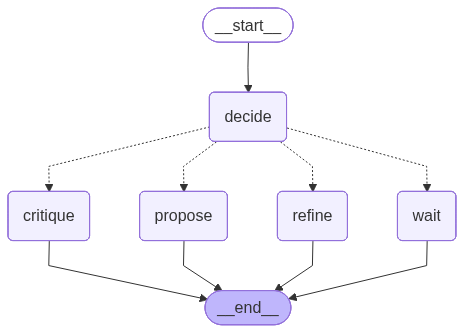

✓ Proposer Agent A created as independent agent


In [3]:
# Define state for proposer agent A
class ProposerAState(TypedDict):
    """State for Autonomous Proposer Agent A."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # The question being debated
    question: str
    # This agent's current proposal
    my_proposal: str
    # The other agent's proposal (if available)
    other_proposal: str
    # This agent's critique of the other's proposal
    my_critique: str
    # Critique received from the other agent
    received_critique: str
    # This agent's refined proposal
    refined_proposal: str
    # What action the agent decided to take (set by decide node)
    decided_action: str
    # Agent's reasoning for its decision
    reasoning: str

# =============================================================================
# NODE 1: DECIDE - Agent analyzes context and chooses an action
# =============================================================================
def agent_a_decide(state: ProposerAState):
    """
    Decision node: Agent analyzes the debate state and decides what action to take.
    This node ONLY makes the decision - it doesn't execute the action. The decision routes to the appropriate action node.
    """
    
    system_prompt = SystemMessage(content="""You are the decision-making component of Autonomous Proposer Agent A.

Your job is to ANALYZE the current debate state and DECIDE what action to take.
You do NOT execute the action - you only decide.

DECISION RULES (apply in order):
1. If my_proposal is empty → decide: "propose"
2. If I have a proposal AND other_proposal exists AND my_critique is empty → decide: "critique"
3. If I have received_critique AND refined_proposal is empty → decide: "refine"
4. Otherwise → decide: "wait"

Respond with ONLY this format:
REASONING: [Brief explanation of what you observe and why you are choosing this action]
DECISION: [propose/critique/refine/wait]""")
    
    context = f"""Current State Analysis:
- Question: {state["question"]}
- My Proposal: {"EXISTS" if state["my_proposal"] else "EMPTY"}
- Other's Proposal: {"EXISTS" if state["other_proposal"] else "EMPTY"}
- My Critique: {"EXISTS" if state["my_critique"] else "EMPTY"}
- Received Critique: {"EXISTS" if state["received_critique"] else "EMPTY"}
- My Refined Proposal: {"EXISTS" if state["refined_proposal"] else "EMPTY"}

What action should I take?"""

    response = llm.invoke([system_prompt, HumanMessage(content=context)])
    response_text = response.content
    
    # Parse the decision
    reasoning = ""
    decision = "wait"
    
    reasoning_match = re.search(r'REASONING:\s*(.+?)(?=DECISION:|$)', response_text, re.DOTALL)
    if reasoning_match:
        reasoning = reasoning_match.group(1).strip()
    
    decision_match = re.search(r'DECISION:\s*(propose|critique|refine|wait)', response_text, re.IGNORECASE)
    if decision_match:
        decision = decision_match.group(1).lower()
    
    return {
        "decided_action": decision,
        "reasoning": reasoning,
        "messages": [AIMessage(content=f"[Agent A DECIDE] Reasoning: {reasoning}\nDecision: {decision}")]
    }

# =============================================================================
# NODE 2: PROPOSE - Executes proposal action
# =============================================================================
def agent_a_propose(state: ProposerAState):
    """Proposal node: Creates initial proposal for the debate."""
    
    system_prompt = SystemMessage(content="""You are Proposer Agent A creating your initial proposal.

Create a thoughtful, well-reasoned proposal that:
- Takes a specific perspective or methodology
- Is clear and defensible
- Focuses on one coherent approach

Your proposal will be critiqued, so make it strong.""")
    
    response = llm.invoke([system_prompt, HumanMessage(content=state["question"])])
    
    return {
        "my_proposal": response.content,
        "messages": [AIMessage(content=f"[Agent A PROPOSE]\n{response.content}")]
    }

# =============================================================================
# NODE 3: CRITIQUE - Executes critique action
# =============================================================================
def agent_a_critique(state: ProposerAState):
    """Critique node: Critiques the other agent's proposal."""
    
    system_prompt = SystemMessage(content="""You are Agent A providing constructive critique.

Critically evaluate the other agent's proposal:
- Identify strengths and weaknesses
- Point out flaws in reasoning or gaps
- Suggest improvements
- Compare with your own approach

Be rigorous but fair.""")
    
    critique_prompt = f"""Your Proposal:
{state["my_proposal"]}

Other Agent's Proposal:
{state["other_proposal"]}

Provide your critique of the other agent's proposal."""

    response = llm.invoke([system_prompt, HumanMessage(content=critique_prompt)])
    
    return {
        "my_critique": response.content,
        "messages": [AIMessage(content=f"[Agent A CRITIQUE]\n{response.content}")]
    }

# =============================================================================
# NODE 4: REFINE - Executes refinement action
# =============================================================================
def agent_a_refine(state: ProposerAState):
    """Refine node: Improves proposal based on received critique."""
    
    system_prompt = SystemMessage(content="""You are Agent A refining your proposal based on critique.

Improve your original proposal by:
- Addressing valid criticisms
- Strengthening weak points
- Incorporating good ideas from the debate
- Maintaining your original strengths

Produce an improved, more robust proposal.""")
    
    refine_prompt = f"""Your Original Proposal:
{state["my_proposal"]}

Critique You Received:
{state["received_critique"]}

Refine your proposal based on this feedback."""

    response = llm.invoke([system_prompt, HumanMessage(content=refine_prompt)])
    
    return {
        "refined_proposal": response.content,
        "messages": [AIMessage(content=f"[Agent A REFINE]\n{response.content}")]
    }

# =============================================================================
# NODE 5: WAIT - No action needed
# =============================================================================
def agent_a_wait(state: ProposerAState):
    """Wait node: Agent has nothing to do, waiting for more context."""
    return {
        "messages": [AIMessage(content="[Agent A WAIT] Waiting for more information...")]
    }

# =============================================================================
# ROUTING FUNCTION - Routes based on agent's decision
# =============================================================================
def route_agent_a_action(state: ProposerAState) -> Literal["propose", "critique", "refine", "wait"]:
    """Route to the appropriate action node based on the agent's decision."""
    return state["decided_action"]

# =============================================================================
# BUILD THE AUTONOMOUS AGENT GRAPH
# =============================================================================
proposer_a_graph = StateGraph(ProposerAState)

# Add all nodes
proposer_a_graph.add_node("decide", agent_a_decide)      # Decision node
proposer_a_graph.add_node("propose", agent_a_propose)    # Action: propose
proposer_a_graph.add_node("critique", agent_a_critique)  # Action: critique
proposer_a_graph.add_node("refine", agent_a_refine)      # Action: refine
proposer_a_graph.add_node("wait", agent_a_wait)          # Action: wait

# Define the flow: START → decide → [route to action] → END
proposer_a_graph.add_edge(START, "decide")

# Conditional routing based on agent's decision
proposer_a_graph.add_conditional_edges(
    "decide",
    route_agent_a_action,
    {
        "propose": "propose",
        "critique": "critique",
        "refine": "refine",
        "wait": "wait"
    }
)

# All action nodes lead to END
proposer_a_graph.add_edge("propose", END)
proposer_a_graph.add_edge("critique", END)
proposer_a_graph.add_edge("refine", END)
proposer_a_graph.add_edge("wait", END)

# Compile the autonomous agent
proposer_a_agent = proposer_a_graph.compile()

# Visualize the agent workflow
display(
    Image(
        proposer_a_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

print("✓ Proposer Agent A created as independent agent")

Proposer agent A is now a complete, independent agent. It has its own state (`ProposerAState`), its own graph with three nodes (propose, critique, refine) and is compiled separately. This agent can be invoked independently by a coordinator. The agent's internal graph now reflects its reasoning process:
1. Decide node: Analyzes state, chooses action.
2. Conditional routing: Routes to appropriate action.
3. Action nodes: Execute the specific action.

### Proposer agent B - Independent agent
This agent is similarly independent, with its own state and graph for proposing, critiquing agent A, and refining based on feedback.

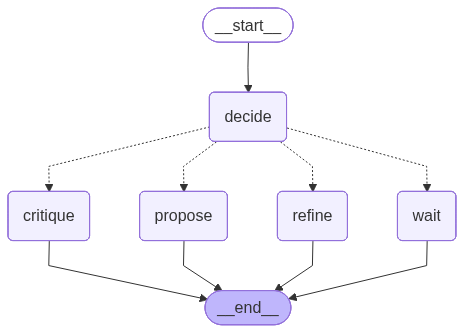

✓ Proposer Agent B created as independent agent


In [4]:
# Define state for proposer agent B - this agent's independent state
class ProposerBState(TypedDict):
    """State for Autonomous Proposer Agent B."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # The question being debated
    question: str
    # This agent's current proposal
    my_proposal: str
    # The other agent's proposal (if available)
    other_proposal: str
    # This agent's critique of the other's proposal
    my_critique: str
    # Critique received from the other agent
    received_critique: str
    # This agent's refined proposal
    refined_proposal: str
    # What action the agent decided to take (set by decide node)
    decided_action: str
    # Agent's reasoning for its decision
    reasoning: str

# =============================================================================
# NODE 1: DECIDE - Agent B analyzes context and chooses an action
# =============================================================================
def agent_b_decide(state: ProposerBState):
    """Decision node: Agent B analyzes the debate state and decides what action to take."""
    
    system_prompt = SystemMessage(content="""You are the decision-making component of Autonomous Proposer Agent B.

Your job is to ANALYZE the current debate state and DECIDE what action to take.
You do NOT execute the action - you only decide.

DECISION RULES (apply in order):
1. If my_proposal is empty AND other_proposal exists → decide: "propose" (offer alternative)
2. If I have a proposal AND other_proposal exists AND my_critique is empty → decide: "critique"
3. If I have received_critique AND refined_proposal is empty → decide: "refine"
4. Otherwise → decide: "wait"

Respond with ONLY this format:
REASONING: [Brief explanation of what you observe and why you're choosing this action]
DECISION: [propose/critique/refine/wait]""")
    
    context = f"""Current State Analysis:
- Question: {state["question"]}
- My Proposal: {"EXISTS" if state["my_proposal"] else "EMPTY"}
- Other's Proposal: {"EXISTS" if state["other_proposal"] else "EMPTY"}
- My Critique: {"EXISTS" if state["my_critique"] else "EMPTY"}
- Received Critique: {"EXISTS" if state["received_critique"] else "EMPTY"}
- My Refined Proposal: {"EXISTS" if state["refined_proposal"] else "EMPTY"}

What action should I take?"""

    response = llm.invoke([system_prompt, HumanMessage(content=context)])
    response_text = response.content
    
    reasoning = ""
    decision = "wait"
    
    reasoning_match = re.search(r'REASONING:\s*(.+?)(?=DECISION:|$)', response_text, re.DOTALL)
    if reasoning_match:
        reasoning = reasoning_match.group(1).strip()
    
    decision_match = re.search(r'DECISION:\s*(propose|critique|refine|wait)', response_text, re.IGNORECASE)
    if decision_match:
        decision = decision_match.group(1).lower()
    
    return {
        "decided_action": decision,
        "reasoning": reasoning,
        "messages": [AIMessage(content=f"[Agent B DECIDE] Reasoning: {reasoning}\nDecision: {decision}")]
    }

# =============================================================================
# NODE 2: PROPOSE - Agent B creates alternative proposal
# =============================================================================
def agent_b_propose(state: ProposerBState):
    """Proposal node: Creates alternative proposal different from Agent A."""
    
    system_prompt = SystemMessage(content="""You are Proposer Agent B creating an ALTERNATIVE proposal.

You've seen Agent A's proposal. Your job is to offer a DIFFERENT perspective:
- Take a contrasting viewpoint or methodology
- Highlight aspects Agent A may have missed
- Be clear and defensible
- Offer genuine alternatives, not just variations

Your proposal will be critiqued, so make it strong.""")
    
    propose_prompt = f"""Question: {state["question"]}

Agent A's Proposal:
{state["other_proposal"]}

Create your alternative proposal with a different perspective."""

    response = llm.invoke([system_prompt, HumanMessage(content=propose_prompt)])
    
    return {
        "my_proposal": response.content,
        "messages": [AIMessage(content=f"[Agent B PROPOSE]\n{response.content}")]
    }

# =============================================================================
# NODE 3: CRITIQUE - Agent B critiques Agent A
# =============================================================================
def agent_b_critique(state: ProposerBState):
    """Critique node: Critiques Agent A's proposal."""
    
    system_prompt = SystemMessage(content="""You are Agent B providing constructive critique of Agent A.

Critically evaluate Agent A's proposal:
- Identify strengths and weaknesses
- Point out flaws in reasoning or gaps
- Suggest improvements
- Compare with your own approach

Be rigorous but fair.""")
    
    critique_prompt = f"""Your Proposal:
{state["my_proposal"]}

Agent A's Proposal:
{state["other_proposal"]}

Provide your critique of Agent A's proposal."""

    response = llm.invoke([system_prompt, HumanMessage(content=critique_prompt)])
    
    return {
        "my_critique": response.content,
        "messages": [AIMessage(content=f"[Agent B CRITIQUE]\n{response.content}")]
    }

# =============================================================================
# NODE 4: REFINE - Agent B refines based on critique
# =============================================================================
def agent_b_refine(state: ProposerBState):
    """Refine node: Improves proposal based on Agent A's critique."""
    
    system_prompt = SystemMessage(content="""You are Agent B refining your proposal based on critique.

Improve your original proposal by:
- Addressing valid criticisms from Agent A
- Strengthening weak points
- Incorporating good ideas from the debate
- Maintaining your original strengths

Produce an improved, more robust proposal.""")
    
    refine_prompt = f"""Your Original Proposal:
{state["my_proposal"]}

Critique from Agent A:
{state["received_critique"]}

Refine your proposal based on this feedback."""

    response = llm.invoke([system_prompt, HumanMessage(content=refine_prompt)])
    
    return {
        "refined_proposal": response.content,
        "messages": [AIMessage(content=f"[Agent B REFINE]\n{response.content}")]
    }

# =============================================================================
# NODE 5: WAIT - No action needed
# =============================================================================
def agent_b_wait(state: ProposerBState):
    """Wait node: Agent has nothing to do, waiting for more context."""
    return {
        "messages": [AIMessage(content="[Agent B WAIT] Waiting for more information...")]
    }

# =============================================================================
# ROUTING FUNCTION
# =============================================================================
def route_agent_b_action(state: ProposerBState) -> Literal["propose", "critique", "refine", "wait"]:
    """Route to the appropriate action node based on the agent's decision."""
    return state["decided_action"]

# =============================================================================
# BUILD AGENT B'S GRAPH
# =============================================================================
proposer_b_graph = StateGraph(ProposerBState)

# Add all nodes
proposer_b_graph.add_node("decide", agent_b_decide)
proposer_b_graph.add_node("propose", agent_b_propose)
proposer_b_graph.add_node("critique", agent_b_critique)
proposer_b_graph.add_node("refine", agent_b_refine)
proposer_b_graph.add_node("wait", agent_b_wait)

# Define the flow
proposer_b_graph.add_edge(START, "decide")

proposer_b_graph.add_conditional_edges(
    "decide",
    route_agent_b_action,
    {
        "propose": "propose",
        "critique": "critique",
        "refine": "refine",
        "wait": "wait"
    }
)

proposer_b_graph.add_edge("propose", END)
proposer_b_graph.add_edge("critique", END)
proposer_b_graph.add_edge("refine", END)
proposer_b_graph.add_edge("wait", END)

# Compile the autonomous agent
proposer_b_agent = proposer_b_graph.compile()

# Visualize the agent workflow
display(
    Image(
        proposer_b_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

print("✓ Proposer Agent B created as independent agent")

Proposer agent B is also a complete, independent agent with its own state, graph and compilation. It deliberately takes a different perspective from agent A to ensure productive debate. The key insight is that each agent reasons about its situation rather than being commanded.

## Part 2: Build independent judge agent
The judge agent synthesizes the best ideas from both refined proposals into a final answer. The judge doesn't need the same autonomous decision-making since it has a single clear purpose.

### Judge agent - Independent agent

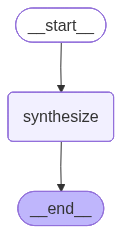

✓ Judge Agent created as independent agent


In [5]:
# Define state for judge agent - this agent's independent state
class JudgeAgentState(TypedDict):
    """State for independent Judge Agent."""
    # The messages field stores this agent's conversation history
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # The original question being addressed
    question: str
    # Agent A's refined proposal
    refined_proposal_a: str
    # Agent B's refined proposal
    refined_proposal_b: str
    # The judge's final synthesis
    final_synthesis: str

def judge_synthesize(state: JudgeAgentState):
    """Judge agent synthesizes both refined proposals into final answer."""
    # System prompt for the judge
    system_prompt = SystemMessage(
        content="""You are a Judge Agent synthesizing a debate between two proposers.
        
        You have seen refined proposals from both agents after they:
        - Made initial proposals
        - Critiqued each other's work
        - Refined their proposals based on feedback
        
        Your task: Create the best possible final answer by:
        - Taking the strongest ideas from both refined proposals
        - Resolving any remaining conflicts or tensions
        - Combining insights into a cohesive, comprehensive response
        - Acknowledging where both agents contributed value
        
        Produce a final answer that's better than either proposal alone.
        """
    )
    
    # Create judgment based on both refined proposals
    judgment_prompt = HumanMessage(
        content=f"""Original Question: {state["question"]}
        
        Agent A's refined proposal:
        {state["refined_proposal_a"]}
        
        Agent B's refined proposal:
        {state["refined_proposal_b"]}
        
        Synthesize the best final answer from both proposals."""
    )
    
    # Judge synthesizes the final answer
    response = llm.invoke([system_prompt, judgment_prompt])
    synthesis_text = response.content
    
    # Return updated state with final synthesis
    return {
        "final_synthesis": synthesis_text,
        "messages": [AIMessage(content=f"[Final Synthesis]\n{synthesis_text}")]
    }

# Build judge agent's graph - this is an independent agent
judge_graph = StateGraph(JudgeAgentState)

# Add node for judge's workflow
judge_graph.add_node("synthesize", judge_synthesize)  # Synthesize final answer

# Define judge's workflow: synthesize and finish
judge_graph.add_edge(START, "synthesize")
judge_graph.add_edge("synthesize", END)

# Compile into an independent agent
judge_agent = judge_graph.compile()

# Visualize the agent workflow
display(
    Image(
        judge_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

print("✓ Judge Agent created as independent agent")

The judge agent is a simple but important independent agent. It takes both refined proposals and creates a synthesis that's better than either alone.

## Part 3: Build the debate coordinator
The coordinator orchestrates the debate flow between the three independent agents. Unlike a traditional coordinator that controls what agents do, the debate facilitator simply:
1. Provides context - Gives agents the information they need.
2. Facilitates rounds - Lets agents act and exchanges their outputs.
3. Observes decisions - Records what each agent chose to do.

The agents themselves decide what action to take based on the context they receive.

### Debate facilitator - Enables autonomous agent interaction

In [6]:
# Define state for the debate facilitator
class DebateFacilitatorState(TypedDict):
    """State for the debate facilitation system."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_question: str
    # Agent A's state
    proposal_a: str
    critique_a_of_b: str
    refined_a: str
    agent_a_last_action: str
    agent_a_reasoning: str
    # Agent B's state
    proposal_b: str
    critique_b_of_a: str
    refined_b: str
    agent_b_last_action: str
    agent_b_reasoning: str
    # Final answer
    final_answer: str
    # Debate tracking
    current_round: int

# =============================================================================
# FACILITATOR FUNCTIONS
# =============================================================================
# The facilitator provides context to agents and records their autonomous decisions.
# It does NOT tell agents what to do - agents decide via their internal graph.

def facilitate_agent_a_turn(state: DebateFacilitatorState):
    """
    Give Agent A the current context and let it decide what to do.
    
    Agent A's internal graph will:
    1. Run DECIDE node (analyze context, choose action)
    2. Route to chosen action node (propose/critique/refine/wait)
    3. Execute the action
    """
    
    # Prepare the context Agent A will see
    agent_a_input = {
        "question": state["user_question"],
        "my_proposal": state["proposal_a"],
        "other_proposal": state["proposal_b"],
        "my_critique": state["critique_a_of_b"],
        "received_critique": state["critique_b_of_a"],
        "refined_proposal": state["refined_a"],
        "decided_action": "",
        "reasoning": ""
    }
    
    # Agent A runs its full internal graph (decide → route → action)
    result = proposer_a_agent.invoke(agent_a_input)
    
    # Record what Agent A decided and did
    action = result["decided_action"]
    reasoning = result["reasoning"]
    
    updates = {
        "agent_a_last_action": action,
        "agent_a_reasoning": reasoning,
        "messages": [AIMessage(content=f"[Facilitator] Agent A decided: {action}")]
    }
    
    # Update state based on Agent A's autonomous decision
    if action == "propose":
        updates["proposal_a"] = result["my_proposal"]
    elif action == "critique":
        updates["critique_a_of_b"] = result["my_critique"]
    elif action == "refine":
        updates["refined_a"] = result["refined_proposal"]
    
    return updates

def facilitate_agent_b_turn(state: DebateFacilitatorState):
    """
    Give Agent B the current context and let it decide what to do.
    Agent B's internal graph handles the decision and execution.
    """

    # Prepare the context Agent B will see
    agent_b_input = {
        "question": state["user_question"],
        "my_proposal": state["proposal_b"],
        "other_proposal": state["proposal_a"],
        "my_critique": state["critique_b_of_a"],
        "received_critique": state["critique_a_of_b"],
        "refined_proposal": state["refined_b"],
        "decided_action": "",
        "reasoning": ""
    }

    # Agent B runs its full internal graph (decide → route → action)
    result = proposer_b_agent.invoke(agent_b_input)

    # Record what Agent B decided and did
    action = result["decided_action"]
    reasoning = result["reasoning"]
    
    updates = {
        "agent_b_last_action": action,
        "agent_b_reasoning": reasoning,
        "messages": [AIMessage(content=f"[Facilitator] Agent B decided: {action}")]
    }

    # Update state based on Agent B's autonomous decision
    if action == "propose":
        updates["proposal_b"] = result["my_proposal"]
    elif action == "critique":
        updates["critique_b_of_a"] = result["my_critique"]
    elif action == "refine":
        updates["refined_b"] = result["refined_proposal"]
    
    return updates

def facilitate_synthesis(state: DebateFacilitatorState):
    """Invoke Judge Agent to synthesize final answer."""
    judge_result = judge_agent.invoke({
        "question": state["user_question"],
        "refined_proposal_a": state["refined_a"],
        "refined_proposal_b": state["refined_b"],
        "final_synthesis": ""
    })
    
    return {
        "final_answer": judge_result["final_synthesis"],
        "messages": [AIMessage(content="[Judge] Final synthesis complete")]
    }

def increment_round(state: DebateFacilitatorState):
    """Track debate rounds."""
    return {"current_round": state["current_round"] + 1}

def should_continue_debate(state: DebateFacilitatorState) -> Literal["continue", "synthesize"]:
    """Check if debate should continue based on agent states."""
    max_rounds = 3
    
    both_refined = bool(state["refined_a"]) and bool(state["refined_b"])
    at_limit = state["current_round"] >= max_rounds
    
    if both_refined or at_limit:
        return "synthesize"
    return "continue"

# Build the Debate Facilitator graph
facilitator_graph = StateGraph(DebateFacilitatorState)

facilitator_graph.add_node("agent_a_turn", facilitate_agent_a_turn)
facilitator_graph.add_node("agent_b_turn", facilitate_agent_b_turn)
facilitator_graph.add_node("increment_round", increment_round)
facilitator_graph.add_node("synthesis", facilitate_synthesis)

facilitator_graph.add_edge(START, "agent_a_turn")
facilitator_graph.add_edge("agent_a_turn", "agent_b_turn")
facilitator_graph.add_edge("agent_b_turn", "increment_round")

facilitator_graph.add_conditional_edges(
    "increment_round",
    should_continue_debate,
    {
        "continue": "agent_a_turn",
        "synthesize": "synthesis"
    }
)

facilitator_graph.add_edge("synthesis", END)

debate_system = facilitator_graph.compile()

print("✓ Debate Facilitator created")

✓ Debate Facilitator created


The system now has a clean two-level architecture:

**Level 1: Facilitator** (outer graph) - Manages debate rounds
```
START → [A's turn] → [B's turn] → [check] → ... → [synthesis] → END
```

**Level 2: Each Agent** (inner graph) - Makes autonomous decisions
```
START → [DECIDE] → [route] → [ACTION] → END
```

When the facilitator invokes an agent, the agent runs its complete internal graph:
1. Decide node analyzes context.
2. Conditional routing selects the action.
3. Action node executes.

### Visualize the debate coordinator workflow

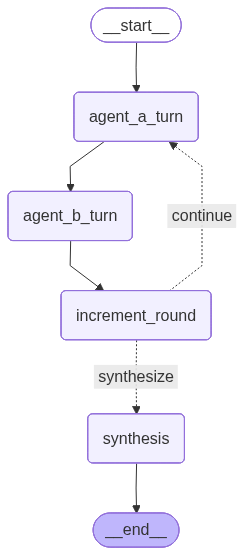

In [7]:
# Visualize the debate coordinator workflow
display(
    Image(
        debate_system.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

The visualization shows how the coordinator orchestrates the debate flow through the phases.

## Part 4: Run the debate system
Let's see the debate multi-agent pattern in action with a question that benefits from multiple perspectives and critical evaluation.

### Example: Climate change debate

In [8]:
# Example: A question that benefits from debate
user_question = "What is the best approach to addressing climate change?"

# Initialize state - note the facilitator doesn't pre-determine agent actions
initial_state = DebateFacilitatorState(
    messages=[HumanMessage(content=user_question)],
    user_question=user_question,
    # Agent A starts with empty state - it will decide what to do
    proposal_a="",
    critique_a_of_b="",
    refined_a="",
    agent_a_last_action="",
    agent_a_reasoning="",
    # Agent B also starts empty
    proposal_b="",
    critique_b_of_a="",
    refined_b="",
    agent_b_last_action="",
    agent_b_reasoning="",
    final_answer="",
    current_round=0
)

# Run the debate multi-agent system
print("=== Starting Debate Multi-Agent System ===")
print(f"\nQuestion: {user_question}\n")
print("\n" + "="*70 + "\n")

result = debate_system.invoke(initial_state)

# Display the autonomous decision-making process
print("\n=== Autonomous Agent Decisions ===")

print(f"\n{'='*70}")
print("Agent A's Reasoning and Decision:")
print(f"{'='*70}")
print(f"Last Action Taken: {result['agent_a_last_action'].upper()}")
print(f"Reasoning: {result['agent_a_reasoning'][:300]}..." if len(result['agent_a_reasoning']) > 300 else f"Reasoning: {result['agent_a_reasoning']}")

print(f"\n{'='*70}")
print("Agent B's Reasoning and Decision:")
print(f"{'='*70}")
print(f"Last Action Taken: {result['agent_b_last_action'].upper()}")
print(f"Reasoning: {result['agent_b_reasoning'][:300]}..." if len(result['agent_b_reasoning']) > 300 else f"Reasoning: {result['agent_b_reasoning']}")

print(f"\n{'='*70}")
print("Agent A's Proposal:")
print(f"{'='*70}")
print(result["proposal_a"][:500] + "..." if len(result["proposal_a"]) > 500 else result["proposal_a"])

print(f"\n{'='*70}")
print("Agent B's Proposal (Alternative Perspective):")
print(f"{'='*70}")
print(result["proposal_b"][:500] + "..." if len(result["proposal_b"]) > 500 else result["proposal_b"])

print(f"\n{'='*70}")
print("Agent A's Critique of Agent B:")
print(f"{'='*70}")
print(result["critique_a_of_b"][:500] + "..." if len(result["critique_a_of_b"]) > 500 else result["critique_a_of_b"])

print(f"\n{'='*70}")
print("Agent B's Critique of Agent A:")
print(f"{'='*70}")
print(result["critique_b_of_a"][:500] + "..." if len(result["critique_b_of_a"]) > 500 else result["critique_b_of_a"])

print(f"\n{'='*70}")
print("Agent A's Refined Proposal:")
print(f"{'='*70}")
print(result["refined_a"][:500] + "..." if len(result["refined_a"]) > 500 else result["refined_a"])

print(f"\n{'='*70}")
print("Agent B's Refined Proposal:")
print(f"{'='*70}")
print(result["refined_b"][:500] + "..." if len(result["refined_b"]) > 500 else result["refined_b"])

print(f"\n{'='*70}")
print("FINAL SYNTHESIZED ANSWER (From Judge Agent):")
print(f"{'='*70}")
print(result["final_answer"])
print(f"{'='*70}\n")

print(f"\nDebate completed in {result['current_round']} rounds.")

=== Starting Debate Multi-Agent System ===

Question: What is the best approach to addressing climate change?




=== Autonomous Agent Decisions ===

Agent A's Reasoning and Decision:
Last Action Taken: REFINE
Reasoning: I have a proposal and there is another proposal present. Additionally, I have critiques for both proposals and have received critiques on my own proposal. However, I still need to refine my proposal based on the critiques received, which is currently empty. Therefore, the next logical step is to ref...

Agent B's Reasoning and Decision:
Last Action Taken: REFINE
Reasoning: I have a proposal and there is another proposal present. I also have a critique and have received a critique as well. However, my refined proposal is empty, which indicates that I need to work on refining my proposal based on the critiques received. Therefore, the next logical step is to refine my p...

Agent A's Proposal:
**Proposal: A Comprehensive Carbon Pricing Strategy as the Best Approach to Ad

In this example, we see autonomous agents with proper internal decision-making:
1. **Round 1:**
   - Agent A's DECIDE node: "My proposal is empty" → Routes to PROPOSE
   - Agent A's PROPOSE node: Executes and creates proposal
   - Agent B's DECIDE node: "I see A's proposal, mine is empty" → Routes to PROPOSE
   - Agent B's PROPOSE node: Creates alternative proposal
2. **Round 2:**
   - Agent A's DECIDE node: "Both proposals exist, no critique yet" → Routes to CRITIQUE
   - Agent B's DECIDE node: Same reasoning → Routes to CRITIQUE
3. **Round 3:**
   - Agent A's DECIDE node: "Received critique, not refined" → Routes to REFINE
   - Agent B's DECIDE node: Same reasoning → Routes to REFINE
4. **Synthesis:** Judge combines the refined proposals

This pattern is ideal for complex problems where multiple valid perspectives exist and where critical evaluation improves outcomes. The debate process ensures that blind spots are identified, weak arguments are strengthened, and the final solution incorporates the best thinking from all participants.